In [1]:
import pandas as pd
import numpy as np
import cv2
import xml
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
# Where is the data?

# Let's do everything from scratch, so that we know what we are doing

In [3]:
# The Bayesian task point us towards this location

# Train data locations
block_0101 = '../../../Spring_2024/S_lab_TasselNet/Block_1_TN/Block_1_images_and_xml'
block_0102 = '../../../Spring_2024/S_lab_TasselNet/Block_2_TN/Block_2_images_and_xml'
block_0203 = '../../../Spring_2024/S_lab_TasselNet/Block_9_TN/Block_9_images_and_xml'
block_0301 = '../../../Spring_2024/S_lab_TasselNet/Block_13_TN/Block_13_images_and_xml'

# train_blocks = [block_0101, block_0102, block_0203, block_0301]

# valid data location
block_0204 = '../../../Spring_2024/S_lab_TasselNet/Block_10_TN/Block_10_images_and_xml'

# valid_blocks = [block_0204]

In [4]:
# Should we do the preprocessing for one block first, and then repeat it for the rest? May be write a function for this?

In [5]:
# consider the block 0101
block_0101_list = os.listdir(block_0101)
block_0101_list.sort()

In [6]:
# from this list, we will only cosider the last 20 time points

# first separate the xml and jpeg files

# xml files
xml_files = [file for file in block_0101_list if file.split('.')[-1] == 'xml']
xml_files.sort()

# jpeg files
jpeg_files = [file for file in block_0101_list if file not in xml_files]
jpeg_files.sort()

In [7]:
# get only the final 20 items of the list -  we are only interested in the final 20 as they are the only ones in the same horizontal direction - meaning capturing the same field over time

chosen_xml_files = xml_files[-20:]
chosen_jpeg_files = jpeg_files[-20:]

# make sure the xml and jpeg files correspond to each other?
np.mean([file.split('.')[0] for file in chosen_xml_files] == [file.split('.')[0] for file in chosen_jpeg_files])

1.0

In [8]:
# Also from these , we need the first 13 image files in the sequence, and the last 7 xml files for our task - Let's specify this
task_specific_image_files = chosen_jpeg_files[:13]
task_specific_xml_files = chosen_xml_files[-7:]

In [9]:
len(task_specific_image_files), len(task_specific_xml_files)

(13, 7)

In [10]:
# Have these in a function for future blocks

def chose_xml_and_jpeg(file_location):
    # list all files in location
    list_of_all_files = os.listdir(file_location)
    # sort files
    list_of_all_files.sort()
    # separate xml and jpeg files
    all_xml_files = [file for file in list_of_all_files if file.split('.')[-1] == 'xml']
    all_jpeg_files = [file for file in list_of_all_files if file not in all_xml_files]
    # get the final 20 files
    chosen_xml_files = all_xml_files[-20:]
    chosen_jpeg_files = all_jpeg_files[-20:]
    # make sure the xml and jpeg files correspond to each other?
    mean = np.mean([file.split('.')[0] for file in chosen_xml_files] == [file.split('.')[0] for file in chosen_jpeg_files])

    # chose the required files only
    task_specific_image_files = chosen_jpeg_files[:13]
    task_specific_xml_files = chosen_xml_files[-7:]
    return(task_specific_image_files, task_specific_xml_files, mean)

In [11]:
# see if this works
try_for_blk1 = chose_xml_and_jpeg(block_0101)
try_for_blk1[-1]

1.0

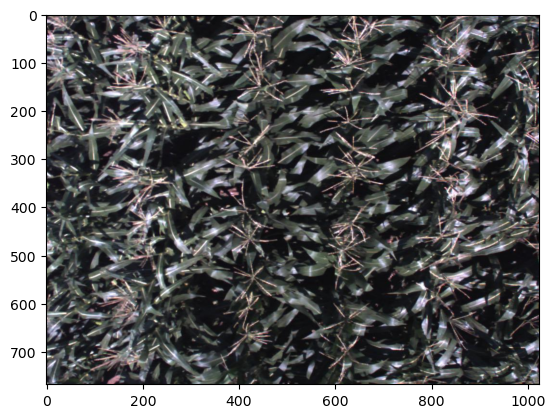

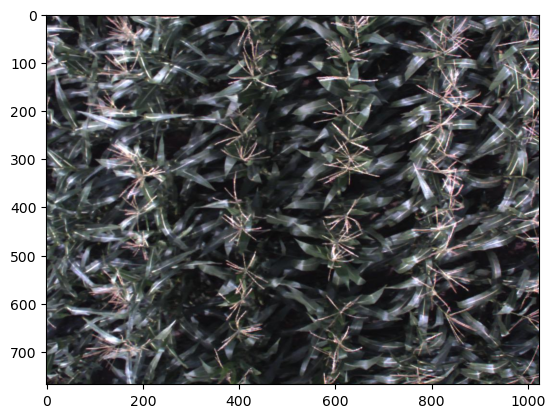

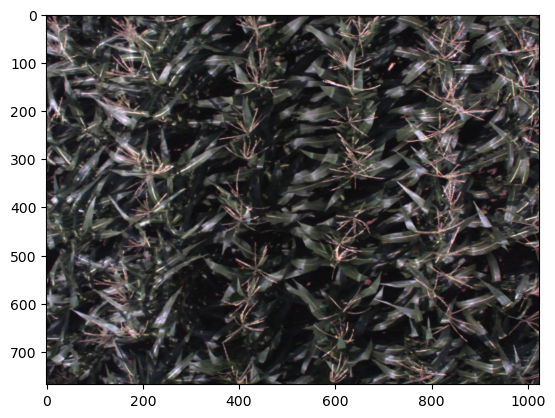

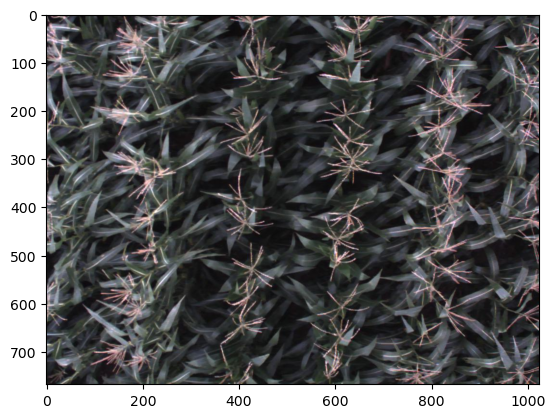

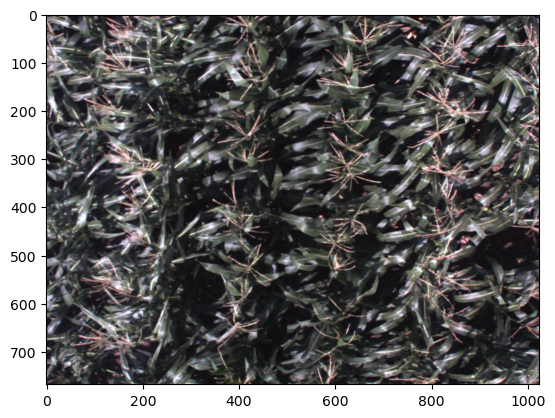

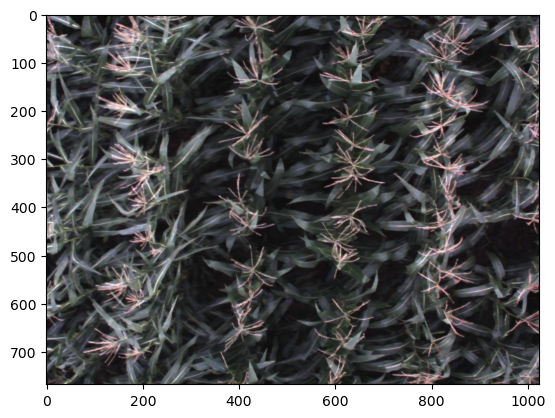

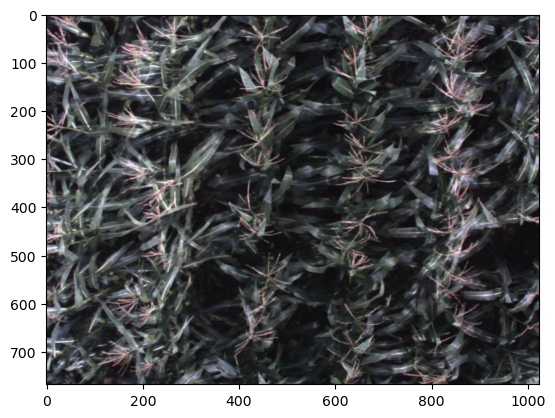

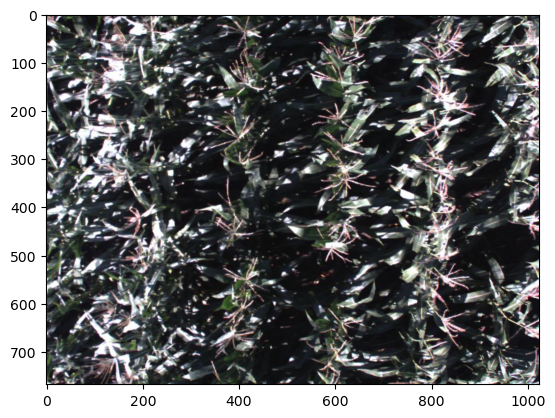

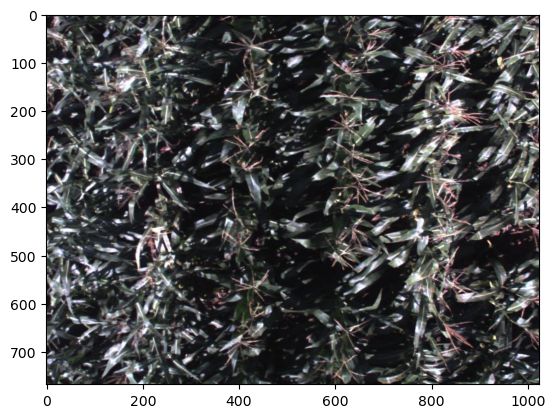

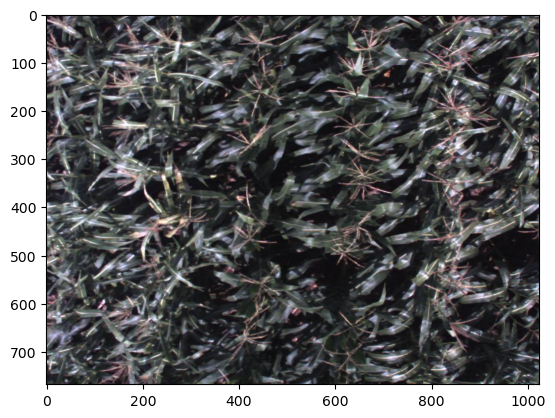

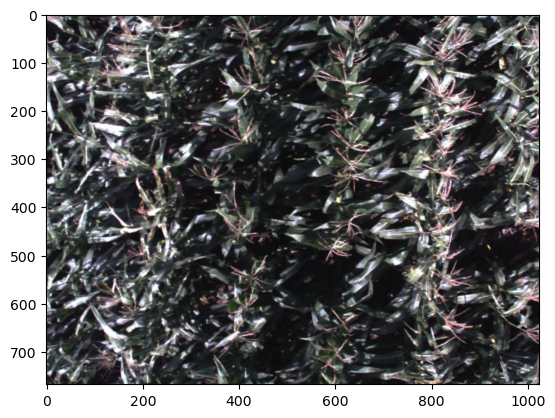

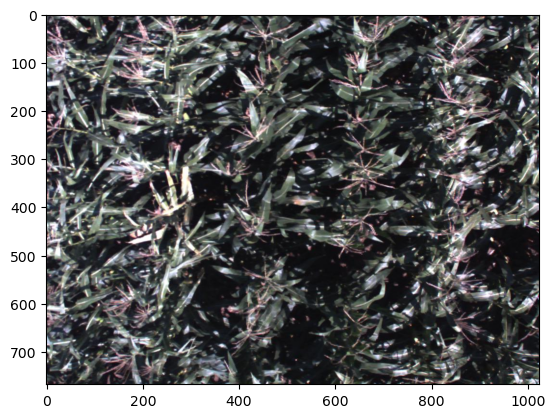

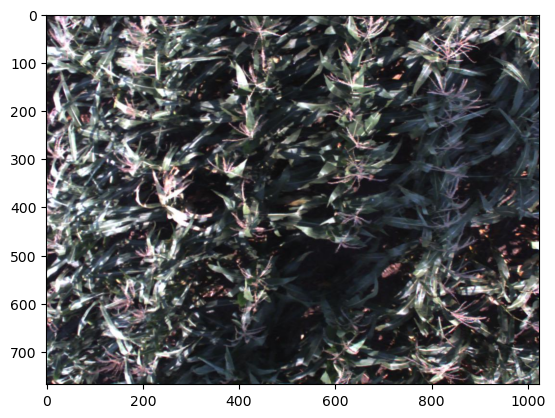

In [12]:
# We need to create the train features and the responses data now

# let's first load the images? - Let's think of the images first, and then the corresponding responses

# load the image data - we need images collected periodically - for each sub-image, the input features should have shape (13, 32, 32, 3) - and the resonse would be of shape (7,)
all_images = []
for file in task_specific_image_files:
    joined_path = os.path.join(block_0101, file)
    read_image = plt.imread(joined_path)
    plt.imshow(read_image)
    plt.show()
    all_images.append(read_image)

In [13]:
# Think of just the first sub-window sequence - what should happen?

# we need to create 32, 32, 3 images for the first 13 images
kernel_size = 32
sub_1_windows = []
for file in all_images:
    chosen_window = file[:kernel_size, :kernel_size, :]
    # use resizing here, as it performs a local kind of normalization
    chosen_window = resize(chosen_window, (32,32,3))
    # plt.imshow(chosen_window)
    # plt.show()
    sub_1_windows.append(chosen_window)

In [14]:
all_images[0].shape

(768, 1024, 3)

In [15]:
len(sub_1_windows)

13

In [16]:
sub_1_windows[0].shape

(32, 32, 3)

In [17]:
# sub_1_windows[0]

In [18]:
# stack these to get the time-wise sub-windows
stacked_sub1_window = np.stack(sub_1_windows)

In [19]:
stacked_sub1_window.shape

(13, 32, 32, 3)

In [20]:
# Okay, now this needs to happen to all sub window sequences - How should we proceed?

In [21]:
%%time
# try writing a stupid function - no idea if this will work

im_height = all_images[0].shape[0]
im_width = all_images[0].shape[1]
stride = 8
kernel_size = 32
n_channels = 3
catch_subwindows_all = []

for i in range(0, im_height, stride):
    for j in range(0, im_width, stride):
        will_this_work = []
        for im_file in all_images:
            chosen_window = im_file[i:i+kernel_size, j:j+kernel_size, :]
            # resize the window
            chosen_window = resize(chosen_window, (kernel_size, kernel_size ,n_channels))
            will_this_work.append(chosen_window)
        catch_subwindows_all.append(will_this_work)

CPU times: user 40 s, sys: 1.52 s, total: 41.5 s
Wall time: 41.7 s


In [22]:
type(catch_subwindows_all)

list

In [23]:
len(catch_subwindows_all)

12288

In [24]:
%%time
# What if we stack all these together?
try_stack = np.stack(catch_subwindows_all)

CPU times: user 1.07 s, sys: 2.58 s, total: 3.65 s
Wall time: 3.67 s


In [25]:
try_stack.shape

(12288, 13, 32, 32, 3)

In [26]:
# Need to verify if what's done above is correct

In [27]:
# Assuming it is, put this inside a function

In [28]:
def create_and_stack_subwindows(im_height, im_width, stride, kernel_size, n_channels, im_list):
    # initiate an empty list
    catch_all_subwindows = []
    for i in range(0, im_height, stride):
        for j in range(0, im_width, stride):
            local_list_at_subimage_sequence_level= []
            for im_file in im_list:
                chosen_window = im_file[i:i+kernel_size, j:j+kernel_size, :]
                # resize the window
                chosen_window = resize(chosen_window, (kernel_size, kernel_size ,n_channels))
                local_list_at_subimage_sequence_level.append(chosen_window)
            catch_all_subwindows.append(local_list_at_subimage_sequence_level)
    # stack all these together
    Stacked_subwindows = np.stack(catch_all_subwindows)
    return(Stacked_subwindows)
    

In [29]:
%%time
# try this
try_this = create_and_stack_subwindows(im_height, im_width, stride, kernel_size, n_channels, all_images)

CPU times: user 39.4 s, sys: 2.47 s, total: 41.9 s
Wall time: 42.1 s


In [30]:
# Verify this code

In [31]:
try_this.shape

(12288, 13, 32, 32, 3)

In [32]:
# Okay, we will verify this

In [33]:
%%time
# Need to add a counter for all the sub-windows getting created for tracking purposes

im_height = all_images[0].shape[0]
im_width = all_images[0].shape[1]
stride = 8
kernel_size = 32
n_channels = 3
catch_subwindows_all = []
sub_window_name_list = []
counter = 0
for i in range(0, im_height, stride):
    for j in range(0, im_width, stride):
        will_this_work = []
        for im_file in all_images:
            chosen_window = im_file[i:i+kernel_size, j:j+kernel_size, :]
            # resize the window
            chosen_window = resize(chosen_window, (kernel_size, kernel_size ,n_channels))
            will_this_work.append(chosen_window)
        catch_subwindows_all.append(will_this_work)
        sub_window_name_list.append("sub_image_seq_" + str(counter))
        counter = counter + 1

CPU times: user 38.6 s, sys: 158 ms, total: 38.8 s
Wall time: 38.9 s


In [34]:
len(sub_window_name_list)

12288

In [35]:
sub_window_name_list[0], sub_window_name_list[-1]

('sub_image_seq_0', 'sub_image_seq_12287')

In [36]:
# First we need to verify that teh wrotten code is correct - Do some sanity checks here before proceeding to make sure that the code written is correct

In [38]:
%%time
# Okay, how to go about this?

# create a stack iwth the created list

stack_alt = np.stack(catch_subwindows_all)

CPU times: user 1.39 s, sys: 1.02 s, total: 2.42 s
Wall time: 2.43 s


In [39]:
stack_alt.shape

(12288, 13, 32, 32, 3)

Sanity checks

In [40]:
# the first subwindow
first_sub_window_seq = stack_alt[0, :,:,:,:]

In [42]:
first_sub_window_seq.shape

(13, 32, 32, 3)

In [43]:
# check if this is the same with the one we already calculated earlier
np.mean(stacked_sub1_window == first_sub_window_seq)

1.0

In [44]:
# check this also with the function output
np.mean(try_this[0,:,:,:,:] == first_sub_window_seq)

1.0

In [45]:
np.mean(try_this[0,:,:,:,:] == stacked_sub1_window)

1.0

In [46]:
# Okay, let's try and get the other subwindows one by one, anc compare with the fucntion output and the last output

In [53]:
sub_window_name_list[1]

'sub_image_seq_1'

In [63]:
# subwindow 2

# we need to create 32, 32, 3 images for the first 13 images
kernel_size = 32
stride = 8
sub_2_windows = []
for file in all_images:
    chosen_window = file[:kernel_size, stride:stride+kernel_size, :]
    # use resizing here, as it performs a local kind of normalization
    chosen_window = resize(chosen_window, (32,32,3))
    # plt.imshow(chosen_window)
    # plt.show()
    sub_2_windows.append(chosen_window)

In [64]:
# file[stride:stride+kernel_size, stride:stride+kernel_size, :].shape

In [65]:
stacked_sub2_window = np.stack(sub_2_windows)

In [66]:
stacked_sub2_window.shape

(13, 32, 32, 3)

In [67]:
# check if this is the same with the one we already calculated earlier
np.mean(stacked_sub2_window == stack_alt[1, :,:,:,:])

1.0

In [72]:
# check this also with the function output
np.mean(try_this[1,:,:,:,:] == stacked_sub2_window)

1.0

In [84]:
# check this also with the function output
np.mean(stack_alt[1,:,:,:,:] == try_this[1,:,:,:,:])

1.0

In [78]:
# Okay, so how many subs we have per row?

# that would be 1024/8 = 128
# how many vertically? - 96



In [82]:
# Let's check some random ones to ensure we are doing his correct

# What about row 5 (idx 4) - sub seq 8(idx 7)
kernel_size = 32
stride = 8
sub_519_windows = []
for file in all_images:
    chosen_window = file[stride*4:stride*4 + kernel_size, stride*7:stride*7+kernel_size, :]
    # use resizing here, as it performs a local kind of normalization
    chosen_window = resize(chosen_window, (32,32,3))
    # plt.imshow(chosen_window)
    # plt.show()
    sub_519_windows.append(chosen_window)

In [70]:
# stacked_sub2_window

In [71]:
# stack_alt[1, :,:,:,:]

In [81]:
# What would be the index of the subwindow here?
127 + 128*3+8

519

In [ ]:
# Let's do the sanity check

In [83]:
# check if this is the same with the one we already calculated earlier
np.mean(sub_519_windows == stack_alt[519, :,:,:,:])

1.0

In [85]:
# check this also with the function output
np.mean(try_this[519,:,:,:,:] == sub_519_windows)

1.0

In [86]:
np.mean(try_this[519,:,:,:,:] == stack_alt[519, :,:,:,:])

1.0

In [87]:
# Could we not do this in a loop though?

In [ ]:
# Need to see how the response should pre prepared as well